## Part 5

In [68]:
import numpy as np
import matplotlib.pyplot as plt

################################################
#Generate 100 data sets of noisy sinusoidal data
################################################

L = 100  # Number of datasets
N = 25  # Number of data points per dataset
noise_std_dev = 0.3  # Standard deviation of Gaussian noise
np.random.seed(0)


# True underlying function
def sin_func(x):
    return np.sin(2 * np.pi * x)

datasets_x = []
datasets_t = []  # t for target (noisy y)
datasets_t_true = []  # true y for reference

x = np.linspace(0, 1, N)  # Evenly spaced x values, same for all datasets

for i in range(L):
    t_true = sin_func(x)
    t_noisy = t_true + np.random.normal(0, noise_std_dev, N)

    datasets_x.append(x)  # All x will be identical
    datasets_t.append(t_noisy) # All different y
    datasets_t_true.append(t_true)

In [69]:
###################################
#Creating Gaussian basis functions
###################################

M_basis = 24  # Number of Gaussian basis functions
M_biases = 1  #  Number of bias term w0
M_total_params = M_basis + M_biases  # Total parameters M


s_gaussian = 0.1  # Width/scale of Gaussian basis functions - hyperparameter
centers = np.linspace(0, 1, M_basis)  # Centers of Gaussians

def gaussian_basis_function(x, mu, s_param):
    return np.exp(-0.5 * ((x - mu) / s_param) ** 2)

def get_phi(x_input, centers, scale_param):
    N_points = len(x_input)
    M_gaussians = len(centers)
    phi = np.ones((N_points, M_gaussians + 1))
    for j in range(M_gaussians):
        phi[:, j + 1] = gaussian_basis_function(x_input, centers[j], scale_param)
    return phi

In [70]:
######################################
# Functions for Fitting and Prediction
######################################

def fit_regularized_least_squares(phi_matrix, t_vector, lambda_reg):
    M_params = phi_matrix.shape[1]
    identity_matrix = np.identity(M_params)
    A = phi_matrix.T @ phi_matrix + lambda_reg * identity_matrix
    b = phi_matrix.T @ t_vector
    try:
        weights = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print(
            f"Warning: Singular matrix encountered with lambda={lambda_reg}.\n"
            f"Using pseudo-inverse."
        )
        weights = np.linalg.pinv(A) @ b
    return weights

def predict(phi_matrix, weights):
    return phi_matrix @ weights

In [71]:
#################################################
#Testing Regularized Least Squares on Actual Data
#################################################

dummy_phi = get_phi(datasets_x[0],centers, s_gaussian)
dummy_t = datasets_t[0] 
dummy_lambda = 0.1   
dummy_w = fit_regularized_least_squares(dummy_phi, dummy_t, dummy_lambda)

print(
    f"Example: Weights calculated using data from dataset 0 (lambda={dummy_lambda}), "
    f"first 5 of {len(dummy_w)} elements:\n{dummy_w[:5]}"
)

Example: Weights calculated using data from dataset 0 (lambda=0.1), first 5 of 25 elements:
[ 0.28824849 -0.20897147 -0.08116755  0.18576994  0.38459313]


### Testing Regularized Least Squares on Actual Data (Dataset 0)

We now use the `get_phi()` and `fit_regularized_least_squares()` functions on real, generated data to verify their correctness.

- **`dummy_phi`** is constructed using `datasets_x[0]`, i.e., the input points from the first dataset.
- **`dummy_t`** holds the corresponding target values from `datasets_t[0]`.
- A test regularization value of λ = 0.1 is used to fit the model.

#### Key Dimensions:
- `dummy_phi` has shape (N, M_total_params) = (25, 25)  
  → 25 input points × 25 basis features (including bias term)
- `dummy_t` has shape (N,) = (25,)

In [72]:
lambda_values = [
    1e-9,  # Very low lambda
    1e-2,  # Medium lambda
    1.0,  # High lambda
]

### Intuition Behind the Choice:
λ = 1e-9 behaves almost like unregularized least squares, where the model tries to fit every noisy detail. It helps show what overfitting looks like.

λ = 1e-2 is moderate, offering a good "middle ground" to observe well-generalized model behavior.

λ = 1.0 is strong regularization, which restricts model flexibility and helps show underfitting or oversmoothing.

Prepared dense x-values (shape: (200,)) and corresponding design matrix (shape: (200, 25)) for plotting smooth curves.

--- Processing for: 1e-09 (λ = 1.00e-09) ---
  Obtained model parameters (weights w) for Dataset 0 with 1e-09:
    Shape of w: (25,)
    First 5 weights (w0 is bias): [-137.29665194  390.79004909 -438.80194281 -154.47948826 1001.14133301]
  Stored 100 prediction curves for 1e-09. Shape: (100, 200)


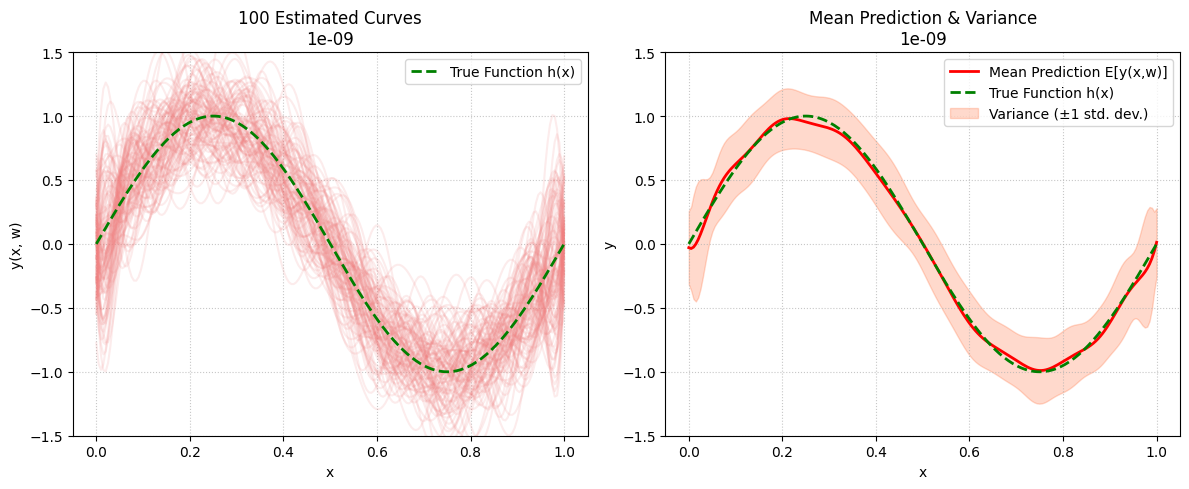


--- Processing for: 0.01 (λ = 1.00e-02) ---
  Obtained model parameters (weights w) for Dataset 0 with 0.01:
    Shape of w: (25,)
    First 5 weights (w0 is bias): [ 1.16688957 -0.60899579 -0.58116866  0.13003692  0.57961854]
  Stored 100 prediction curves for 0.01. Shape: (100, 200)


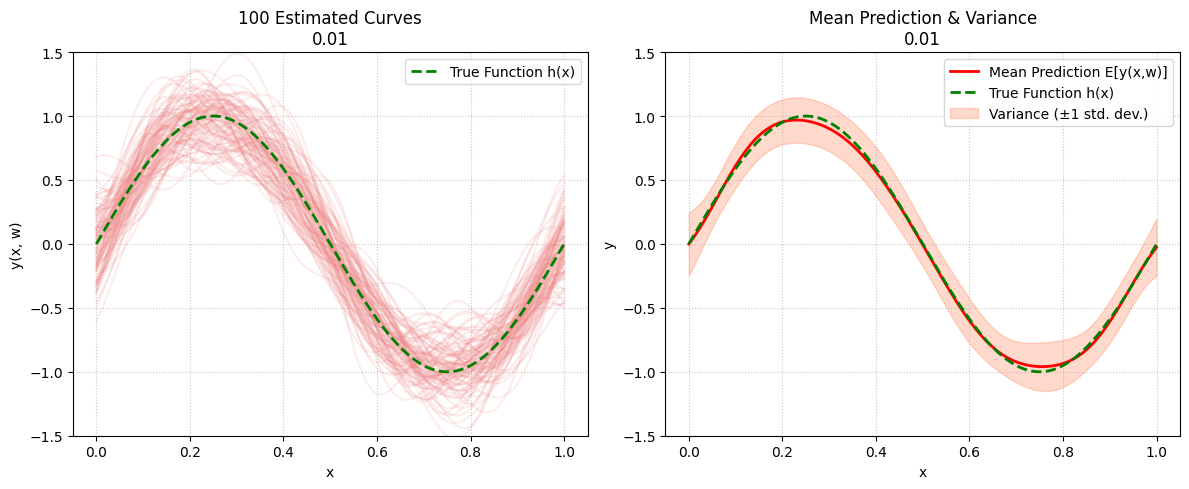


--- Processing for: 1.0 (λ = 1.00e+00) ---
  Obtained model parameters (weights w) for Dataset 0 with 1.0:
    Shape of w: (25,)
    First 5 weights (w0 is bias): [ 0.13766307 -0.01958793  0.06096215  0.16550728  0.24029799]
  Stored 100 prediction curves for 1.0. Shape: (100, 200)


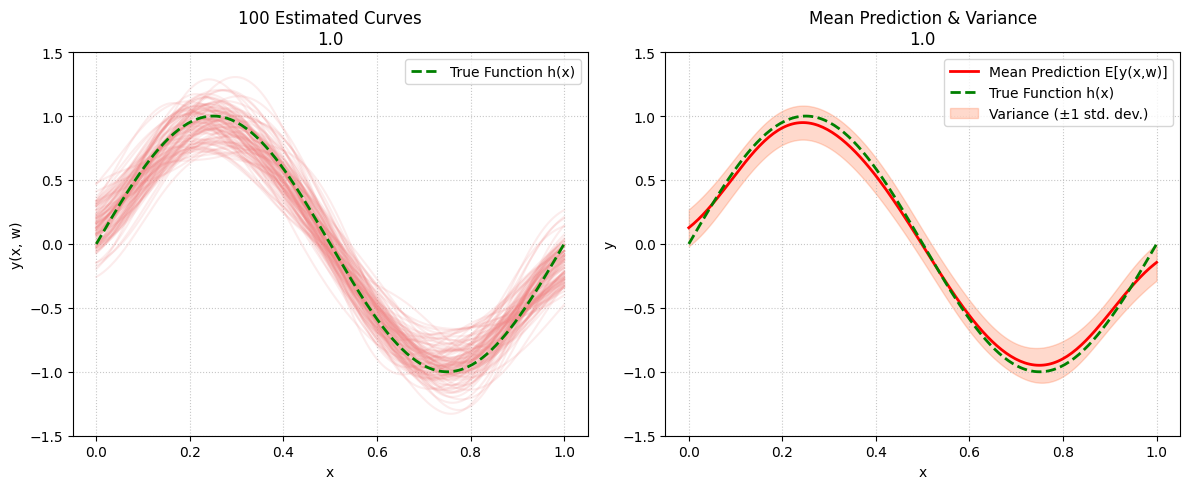


All plots displayed.



In [73]:
#################################################
# Generating Plots for Bias-Variance Illustration
#################################################

x_plot_dense = np.linspace(0, 1, 200)
phi_plot_dense = get_phi(x_plot_dense, centers, s_gaussian)
print(
    f"Prepared dense x-values (shape: {x_plot_dense.shape}) and corresponding design matrix (shape: {phi_plot_dense.shape}) for plotting smooth curves."
)

all_predictions_by_lambda = {}

for i, lambda_reg_val in enumerate(lambda_values):
    current_lambda_name = lambda_values[i]
    print(f"\n--- Processing for: {current_lambda_name} (λ = {lambda_reg_val:.2e}) ---")

    predictions_for_current_lambda_list = []

    # To print weights for one dataset (e.g., the first one) for this lambda
    first_dataset_weights_printed = False

    plt.figure(figsize=(12, 5))  # Figure for the two subplots for current lambda
    plt.subplot(1, 2, 1)  # Left subplot: 100 estimated curves

    for l_idx in range(L):  # Loop through each of the L datasets
        x_train_dataset = datasets_x[l_idx]
        t_train_dataset = datasets_t[l_idx]

        phi_train_dataset = get_phi(
            x_train_dataset,centers, s_gaussian
        )
        w_estimated = fit_regularized_least_squares(
            phi_train_dataset, t_train_dataset, lambda_reg_val
        )

        if (
            l_idx == 0 and not first_dataset_weights_printed
        ):  # Print weights for the first dataset only
            print(
                f"  Obtained model parameters (weights w) for Dataset 0 with {current_lambda_name}:"
            )
            print(f"    Shape of w: {w_estimated.shape}")
            print(f"    First 5 weights (w0 is bias): {w_estimated[:5]}")
            first_dataset_weights_printed = True

        y_pred_dense_single_fit = predict(phi_plot_dense, w_estimated)
        predictions_for_current_lambda_list.append(y_pred_dense_single_fit)
        plt.plot(x_plot_dense, y_pred_dense_single_fit, color="lightcoral", alpha=0.15)

    all_predictions_by_lambda[lambda_reg_val] = np.array(
        predictions_for_current_lambda_list
    )
    print(
        f"  Stored {L} prediction curves for {current_lambda_name}. Shape: {all_predictions_by_lambda[lambda_reg_val].shape}"
    )

    plt.plot(
        x_plot_dense,
        sin_func(x_plot_dense),
        color="green",
        linestyle="--",
        linewidth=2,
        label="True Function h(x)",
    )
    plt.title(f"100 Estimated Curves\n{current_lambda_name}")
    plt.xlabel("x")
    plt.ylabel("y(x, w)")
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="upper right")
    plt.grid(True, linestyle=":", alpha=0.7)

    plt.subplot(1, 2, 2)  # Right subplot: Mean and variance
    mean_prediction_curve = np.mean(all_predictions_by_lambda[lambda_reg_val], axis=0)
    std_dev_prediction_curves = np.std(
        all_predictions_by_lambda[lambda_reg_val], axis=0
    )

    plt.plot(
        x_plot_dense,
        mean_prediction_curve,
        color="red",
        linewidth=2,
        label="Mean Prediction E[y(x,w)]",
    )
    plt.plot(
        x_plot_dense,
        t(x_plot_dense),
        color="green",
        linestyle="--",
        linewidth=2,
        label="True Function h(x)",
    )
    plt.fill_between(
        x_plot_dense,
        mean_prediction_curve - std_dev_prediction_curves,
        mean_prediction_curve + std_dev_prediction_curves,
        color="orangered",
        alpha=0.2,
        label="Variance (±1 std. dev.)",
    )

    plt.title(f"Mean Prediction & Variance\n{current_lambda_name}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="upper right")
    plt.grid(True, linestyle=":", alpha=0.7)

    plt.tight_layout()
    plt.show()

print("\nAll plots displayed.\n")

### Bias-Variance Trade-off Observations

#### Key Concepts:
- Bias: This shows how far the average prediction of our model is from the actual function we want to learn.
  → High bias means the model is too simple and misses the real pattern (called underfitting).

- Variance: This tells us how much the model’s predictions change when we train it on different datasets.
  → High variance means the model is too sensitive to the training data and may not work well on new data (called overfitting).

- Total Error ≈ Bias² + Variance + Irreducible Error:
  The total error includes:

- Error from wrong assumptions (bias),

- Error from model's sensitivity (variance),

- Plus some random noise we can't remove.

- Regularization (λ): A way to prevent the model from becoming too complex.
  → Higher λ = more control on model, smaller weights, and lower risk of overfitting.

### Observations for Each Regularization Level:

**1. Low λ (e.g., `1.00e-09`):**
*   Printed Weights (Dataset 0): The weights (e.g., `w_estimated[:5]`) might show larger magnitudes compared to higher lambda values, reflecting the model's attempt to fit the data closely.
*   **Plot 1 (100 Estimated Curves):**
    *   Observation: The 100 individual estimated curves (light red) exhibit a wide spread. They wiggle significantly.
    *   Interpretation: High variance. The model is overfitting.
*   **Plot 2 (Mean Estimated Curve & Variance):**
    *   Observation (Mean Curve): The mean estimated curve (solid red) matches with the true sinusoidal function (green dashed line) very closely.
    *   Interpretation (Mean Curve): Low bias.
    *   Observation (Variance Band): The shaded orange area is wide.
    *   Interpretation (Variance Band): Confirms high variance.

**2. Medium λ (e.g., `0.1`):**
*   Printed Weights (Dataset 0): The magnitudes of weights (e.g., `w_estimated[:5]`) are likely smaller/more constrained than for low λ.
*   **Plot 1 (100 Estimated Curves):**
    *   Observation: The spread of the 100 individual curves is noticeably narrower.
    *   Interpretation:REDUCED VARIANCE.
*   Plot 2 (Mean Estimated Curve & Variance):
    *   Observation (Mean Curve): The mean estimated curve (solid red) is reasonably close to the true function.
    *   Interpretation (Mean Curve):* Bias might be slightly higher than for low λ, but relatively low.
    *   Observation (Variance Band): The shaded orange area is narrower.
    *   Interpretation (Variance Band): Shows reduced variance.

**3. High λ (e.g., `1.0`):**
*   Printed Weights (Dataset 0): The weights (e.g., `w_estimated[:5]`) are likely very small, with many close to zero, especially for the basis functions. The bias term `w0` might dominate if it's trying to fit the average of the sine wave.
*   **Plot 1 (100 Estimated Curves):**
    *   Observation: The 100 individual curves are very tightly clustered and much flatter.
    *   Interpretation: Very low variance.
*   **Plot 2 (Mean Estimated Curve & Variance):**
    *   Observation (Mean Curve): The mean estimated curve (solid red) is noticeably different and much simpler than the true function.
    *   Interpretation (Mean Curve): Has high bias. The model is underfitting.
    *   Observation (Variance Band): The shaded orange area is very narrow.
    *   Interpretation (Variance Band): Confirms very low variance.

### Describing the Bias-Variance Trade-off:

The six plots and the behavior of the estimated weights for different λ values clearly demonstrate the bias-variance trade-off:

*   **Low λ:** High model complexity allowed, leading to low bias (average fit is good) but high variance (fits vary wildly with data). Weights can be large.
*   **High λ:** Low model complexity forced by regularization, leading to high bias (average fit is poor, too simple) but low variance (fits are very stable). Weights are small.
*   **Medium λ:** Aims for a sweet spot where the model is complex enough to capture the true signal (moderate bias) but not so complex that it fits the noise (moderate variance). Weights are balanced.

The parameters used (`L=100`, `N=25`, `M_total_params=25`, `noise_std_dev=0.3`, `s_gaussian=0.1`) create a scenario where overfitting is likely without regularization because the number of parameters is equal to the number of data points. Regularization (λ) is crucial for controlling this.

## Part 6

In [93]:
##################################
#Generating 100 noisy observations
##################################

np.random.seed(0)
# Generate 100 points uniformly in [0, 1]
x = np.linspace(0, 1, 100)
x = x.reshape(-1,1)
t = (sin_func(x) + np.random.normal(0, 0.1, size=x.shape)).flatten() # noise std = 0.1

In [94]:
############################################################################
#Fitting a regularized least squares model using 20 Gaussian basis functions
############################################################################

# Choose 20 basis functions with centers evenly spaced in [0,1]
M = 20
centers = np.linspace(0, 1, M)
centers = centers.reshape(1,-1)
sigma = 0.05  # width of each Gaussian
Phi = gaussian_basis_function(x, centers, sigma)

# Predict
lamda = 0.01
x_test = np.linspace(0, 1, 1000)
x_test = x_test.reshape(-1,1)
w = fit_regularized_least_squares(Phi,t,lamda)
Phi_test = gaussian_basis_function(x_test, centers, sigma)
y_pred = Phi_test @ w


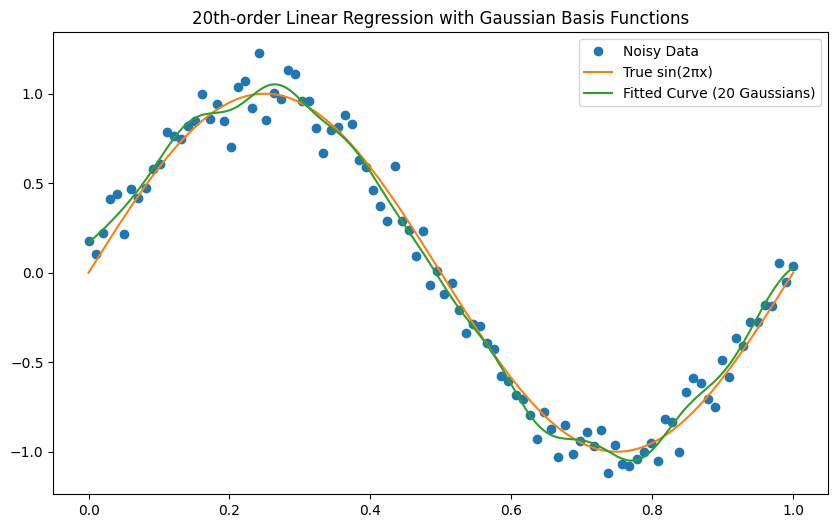

In [95]:
##############################################
#Plotting the Gaussian kernel regression model
##############################################

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, t, 'o', label='Noisy Data')
plt.plot(x_test, sin_func(x_test), label='True sin(2πx)')
plt.plot(x_test, y_pred, label='Fitted Curve (20 Gaussians)')
plt.legend()
plt.title('20th-order Linear Regression with Gaussian Basis Functions')
plt.show()

In [96]:
def bayesian_update(prior_mean, prior_cov, phi_x, t_val, sigma2):
    """
    Update the posterior mean and covariance with a new (phi_x, t_val) pair.
    """
    phi_x = phi_x.reshape(-1, 1)  # Ensure column vector
    S_inv = np.linalg.inv(prior_cov)
    
    # Update posterior covariance
    S_new_inv = S_inv + (1 / sigma2) * (phi_x @ phi_x.T)
    S_new = np.linalg.inv(S_new_inv)
    
    # Update posterior mean
    m_new = S_new @ (S_inv @ prior_mean + (1 / sigma2) * phi_x.flatten() * t_val)
    
    return m_new, S_new


### Entire intution behind `bayesian_update()`

**1. Start with a Prior Distribution**

We begin with a prior belief about the weights. This belief is represented as a multivariate Gaussian distribution:

- The mean represents our best guess.
- The covariance represents our uncertainty.

**2. Observe One Data Point**

We now observe one data point:
- An input `x` (transformed using basis functions into a vector `phi_x`)
- A target value `t`

We assume the relationship between the weights and the output follows a linear model with Gaussian noise.

**3. Define the Likelihood**

Next, we write down the likelihood — the probability of observing the target `t` given the weights and the input.
This likelihood is also a Gaussian, centered around the dot product of the weights and the input vector.
This means the target `t` is normally distributed around the model’s prediction.  
So, the likelihood — the probability of observing `t` given the weights and input is Gaussian.
So the mean of the likelihood function is `t`.

Variance of the likelihood function controls the width of the Gaussian bell curve.

Small variance: implies high confidence in predictions (narrow likelihood).

Large large: implies less confidence (broad likelihood, allowing more deviation from prediction).

Hence we use noise variance in the Gaussian likelihood function because it mathematically models how much random variation (or noise) we expect in the observed data, given the model’s prediction.

**Why did we assume Gaussian noise?**

1. Gaussian likelihood + Gaussian prior = Gaussian posterior. This gives a simple, closed-form solution.

2. Many small, random influences (e.g., sensor noise) add up to approximate a normal distribution (Central Limit Theorem).
   In general most naturally occuring data follows Gaussian Distribution.

3. We can compute the posterior exactly using matrix operations — no sampling or approximation needed.


**4. Apply Bayes' Rule**

Bayes’ rule says:

*Posterior ∝ Likelihood × Prior*

Because both the prior and the likelihood are Gaussian, their product is also a Gaussian. This means the posterior distribution will be Gaussian too.
We can calculate the mean and variance of the posterior distribution by multiplying the likelihood and prior.

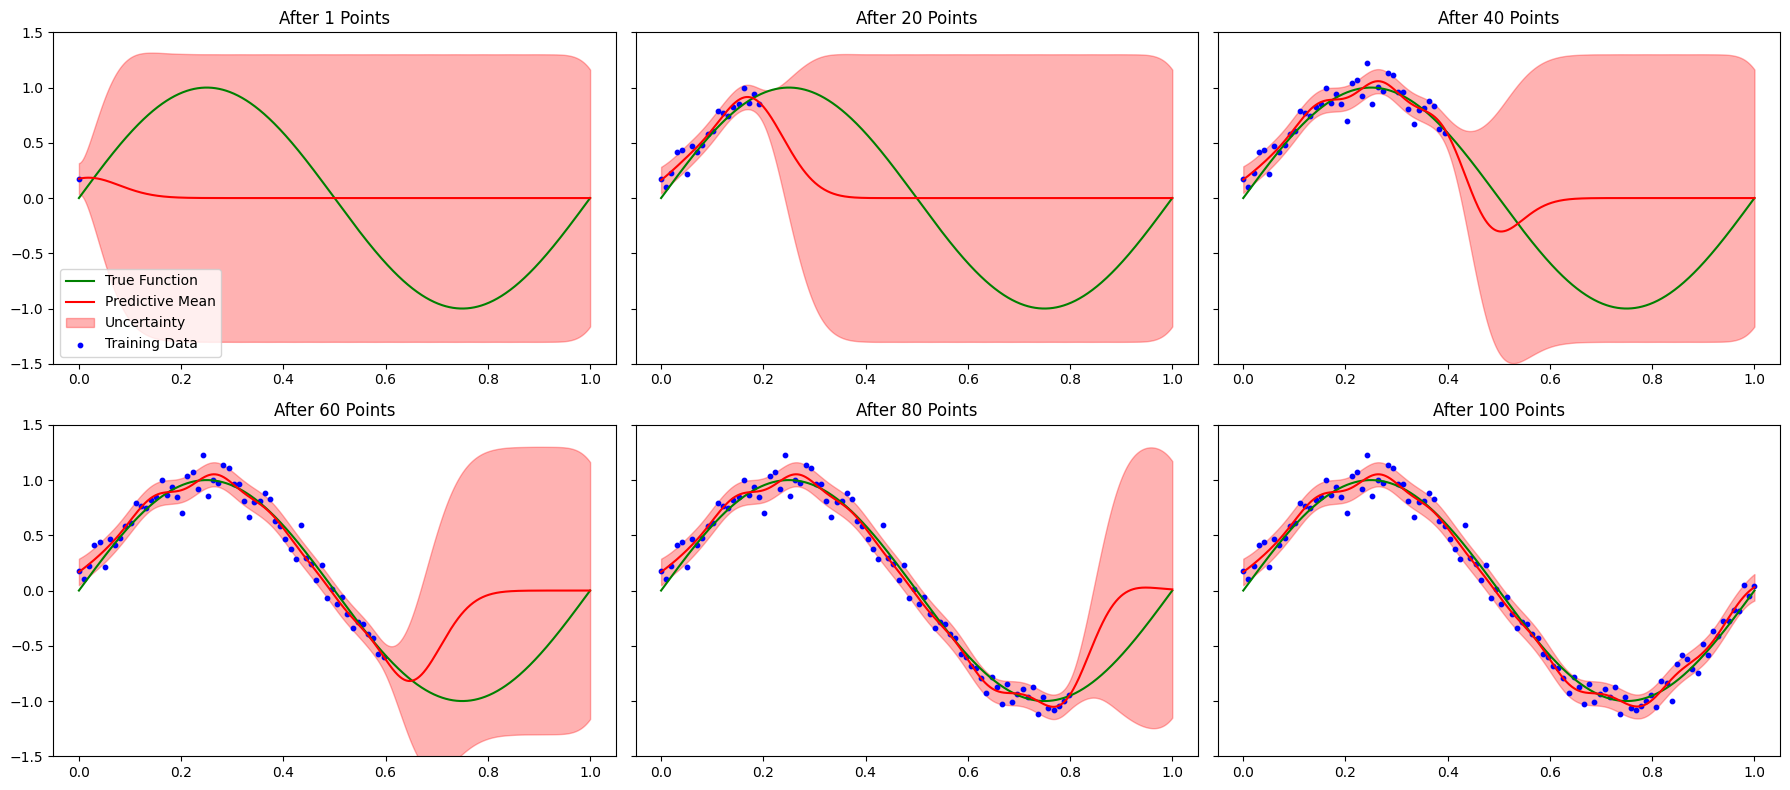

In [97]:
###############################################################################
#Sequentially update the posterior and plot the predictive mean and uncertainty
###############################################################################

sigma2 = 0.01              # Known noise variance (σ²)
m_N = np.zeros(M)      # Prior mean: zero vector
S_N = np.eye(M)        # Prior covariance: identity matrix

# Number of training data for plotting
plot_points = [1, 20, 40, 60, 80, 100]
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
axs = axs.flatten()

for i in range(Phi.shape[0]):
    phi_xi = Phi[i]
    t_i = t[i]
    m_N, S_N = bayesian_update(m_N, S_N, phi_xi, t_i, sigma2) # mean and variance at ith step

    if (i + 1) in plot_points:
        mean_pred = Phi_test @ m_N
        var_pred = np.sum(Phi_test @ S_N * Phi_test, axis=1) + sigma2
        std_pred = np.sqrt(var_pred)

        ax = axs[plot_points.index(i + 1)]
        ax.plot(x_test, sin_func(x_test), 'g', label="True Function")
        ax.plot(x_test, mean_pred, 'r', label="Predictive Mean")
        ax.fill_between(x_test.flatten(),
                        mean_pred - std_pred,
                        mean_pred + std_pred,
                        alpha=0.3, color='red', label="Uncertainty")
        ax.scatter(x[:i+1], t[:i+1], color='blue', s=10, label="Training Data")
        ax.set_title(f"After {i+1} Points")
        ax.set_ylim(-1.5, 1.5)
        if plot_points.index(i + 1) == 0:
            ax.legend()

plt.tight_layout()
plt.show()


#### Intution behind the above code

This code performs Bayesian regression with sequential updates, showing how the model's predictive mean and uncertainty evolve as more training data is observed.

Initially, the model assumes a standard normal prior over weights, meaning it expects the weights to be centered at zero with unit variance. The observation noise is modeled with a known variance of 0.01.

For each new training point, the model updates its posterior distribution over weights using Bayesian updating. This involves computing a new posterior mean and covariance after incorporating the new data point.

At specific points (e.g., after 1, 20, 40, 60, 80, and 100 data points), the model calculates the predictive distribution for the test inputs. It plots:
- The true function (green)
- The predictive mean (red curve)
- The uncertainty (red shaded region representing mean ± standard deviation)
- The training points observed so far (blue dots)

#### Observations

1. **For learned regions:**

The model becomes confident — predictive mean aligns with data, and uncertainty (variance) becomes low.

2. **For unseen regions:**

The model defaults to the prior mean (usually 0), and the uncertainty stays high (close to 1, depending on prior and noise variance).

3. In the final plot (100 points) uncertainty is the lowest because the model has learned the function well using all the data points.

4. Uncertainty shrinks specifically where data is present — not globally. Even in the 100-point plot, edges like x≈0 and x≈1 may still show slightly more uncertainty due to data sparsity.


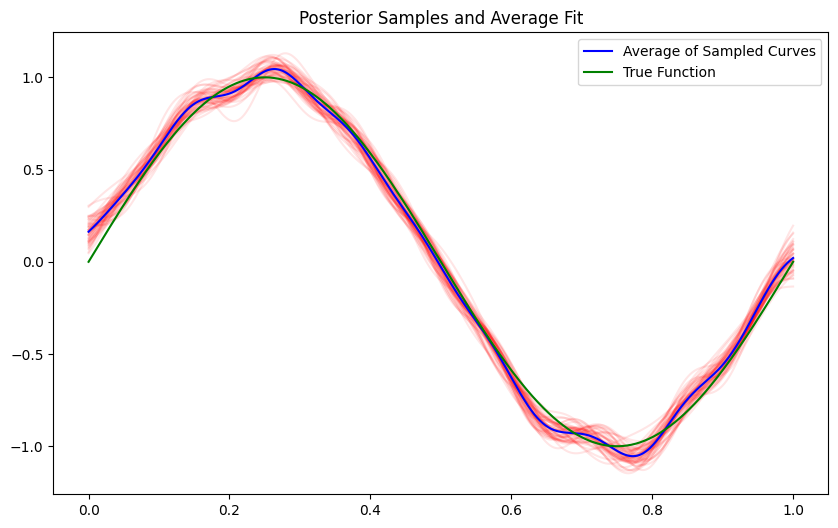

In [98]:
###################################################
# Plotting Posterior Sampling and Average Curve Fit
###################################################

n_samples = 50
sampled_curves = []

for _ in range(n_samples):
    w_sample = np.random.multivariate_normal(mean=m_N, cov=S_N)
    y_sample = predict(Phi_test, w_sample)
    sampled_curves.append(y_sample)

sampled_curves = np.array(sampled_curves)
average_curve = np.mean(sampled_curves, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

plt.figure(figsize=(10, 6))
for i in range(n_samples):
    plt.plot(x_test, sampled_curves[i], color='red', alpha=0.1)

plt.plot(x_test, average_curve, label='Average of Sampled Curves', color='blue')
plt.plot(x_test, sin_func(x_test), label='True Function', color='green')
plt.legend()
plt.title("Posterior Samples and Average Fit")
plt.show()


#### Intution behind above code

This code visualizes what the posterior distribution over weights actually means, by drawing multiple random samples from it and plotting their corresponding functions.

After training the Bayesian model on all 100 data points, we’ve calculated the final posterior mean m_N and posterior covariance S_N. These encode everything the model believes about the true weights given the data.

We now sample 50 random weight vectors w_sample from the multivariate normal distribution defined by this posterior.

For each sample, we compute the predicted curve: y_sample = Φ_test @ w_sample

This gives us 50 possible fits which reflect the uncertainty in the model's parameters.

Finally we get the average of these 50 curves approximates the posterior predictive mean.

It’s plotted in blue, and compared with the true function in green.

#### Observations

- The red curves are tightly packed where there is more data. Hence it shows more confidence where data is more abundant.  This observation is similar to that of the previous plot.

- The mean curve in the second plot (average of sampled curves) and the predictive mean in the first plot's final panel (after 100 data points) should be almost identical, because both curves represent the Bayesian posterior predictive mean.
  In the first plot, it’s computed analytically whereas in the second plot, we sample many weight vectors and take the average over all sampled predictions.
  As long as we use enough samples (e.g., 50+), the sample average converges closely to the analytical mean.